In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd 
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

from PIL import Image
import imageio

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

## Load Data

In [2]:
train_data = pd.read_csv('re_train_id_label.csv')
val_data = pd.read_csv('re_val_id_label.csv')

In [3]:
testing_data = pd.read_csv('test_id.csv')

In [4]:
print('Training data size: ' , len(train_data))
print('Validation data size: ' , len(val_data))
print('Testing data size: ', len(testing_data))

Training data size:  16145
Validation data size:  8694
Testing data size:  3830


In [40]:
'''
train_mask = np.random.rand(len(train)) < 0.7
train_data = train[train_mask]
train_data.reset_index(inplace=True)

val_mask = np.random.rand(len(val)) < 0.7
val_data = val[val_mask]
val_data.reset_index(inplace=True)
'''

## Data Preprocessing 

In [5]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
def load_data(data):
    x = []
    y = (data['label'])

    index = 0
    for id in tqdm(data['id']):
        image_id = id
        if data['label'][index] == 0:
            label = 'good_all'
        else:
            label = 'defect'
        image_path = './train/train_contest/' + label + '/' + image_id
        image = Image.open(image_path)
        image = image.convert('RGB')
        #image = np.array(image, dtype=np.uint8)
        #plt.imshow(image)
        #plt.gca().axis('off')
        x.append(preprocess(image))
        index += 1
    return x, y

In [7]:
train_x, train_y = load_data(train_data)
val_x, val_y = load_data(val_data)

100%|██████████| 8694/8694 [00:11<00:00, 740.83it/s]


In [8]:
test_x = []
for image_id in tqdm(testing_data['id']):
    image_path = './test/test_contest/test/' + image_id
    image = Image.open(image_path)
    image = image.convert('RGB')
    #plt.imshow(image)
    #plt.gca().axis('off')
    test_x.append(preprocess(image))

100%|██████████| 3830/3830 [00:04<00:00, 892.90it/s]


In [9]:
data = {
    'train': list(zip(train_x, train_y)),
    'val': list(zip(val_x, val_y)),
    'test': test_x
}

dataloaders = { x: torch.utils.data.DataLoader(data[x], batch_size=16,shuffle=True, num_workers=4) for x in ['train', 'val']}

dataloaders['test'] = torch.utils.data.DataLoader(data['test'], batch_size=16,shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(train_x),
    'val': len(val_x),
    'test': len(test_x)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Training

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                y_pred, y_true = np.array([]), np.array([])

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            for inputs, labels in tqdm(dataloaders[phase]):
                if phase == "val":
                    y_true = np.append(y_true, np.array(labels))

                inputs = inputs.to(device)
                labels = labels.to(device)

                if torch.cuda.is_available():
                    model.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase == "val":
                    y_pred = np.append(y_pred, preds.detach().cpu().numpy())
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == "val":
                print('AUC score: ' + str(roc_auc_score(y_true, y_pred)))
                print()
                cf_matrix = confusion_matrix(y_true, y_pred)
                print(classification_report(y_true, y_pred, labels=[0, 1]))
                sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
                plt.show(block=False)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def prediction(model):
    test_y = np.array([])
    with torch.no_grad():
        for data in tqdm(dataloaders['test']):
            data = data.to(device)
            if torch.cuda.is_available():
                model.cuda()
            outputs = model(data)
            for i in range(len(outputs)):
                probs = torch.nn.functional.softmax(outputs[i],dim=0)
                test_y = np.append(test_y, probs[1].detach().cpu().numpy())

    return test_y

## ResNet Model

In [17]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

  0%|          | 0/1010 [00:00<?, ?it/s]
Epoch 1/3
----------
  0%|          | 0/544 [00:00<?, ?it/s]
train Loss: 0.1830 Acc: 0.9264
100%|██████████| 544/544 [00:08<00:00, 66.30it/s]
val Loss: 0.1118 Acc: 0.9602
AUC score: 0.9658525463300744

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      6230
           1       0.89      0.98      0.93      2464

    accuracy                           0.96      8694
   macro avg       0.94      0.97      0.95      8694
weighted avg       0.96      0.96      0.96      8694




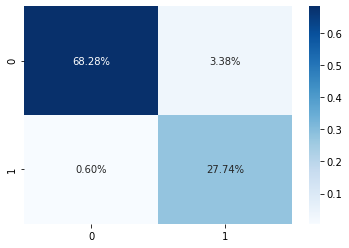

  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch 2/3
----------
  0%|          | 0/544 [00:00<?, ?it/s]
train Loss: 0.0654 Acc: 0.9770
100%|██████████| 544/544 [00:08<00:00, 66.41it/s]

val Loss: 0.0924 Acc: 0.9679
AUC score: 0.971352418648767

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      6230
           1       0.91      0.98      0.95      2464

    accuracy                           0.97      8694
   macro avg       0.95      0.97      0.96      8694
weighted avg       0.97      0.97      0.97      8694



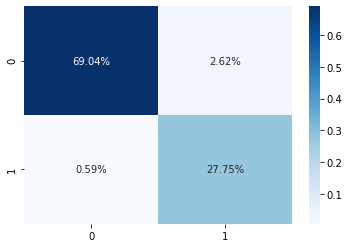

  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch 3/3
----------
  0%|          | 0/544 [00:00<?, ?it/s]
train Loss: 0.0398 Acc: 0.9862
100%|██████████| 544/544 [00:08<00:00, 66.49it/s]
val Loss: 0.0831 Acc: 0.9762
AUC score: 0.9765175835400555

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6230
           1       0.94      0.98      0.96      2464

    accuracy                           0.98      8694
   macro avg       0.97      0.98      0.97      8694
weighted avg       0.98      0.98      0.98      8694




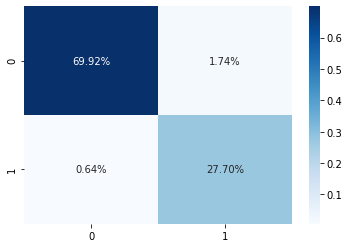


Training complete in 2m 9s
Best val Acc: 0.976190


In [18]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

In [ ]:
#torch.save(model, './model/resnet50')

In [22]:
resnet_pred = prediction(model)

100%|██████████| 240/240 [00:03<00:00, 60.50it/s]


<AxesSubplot:ylabel='Density'>

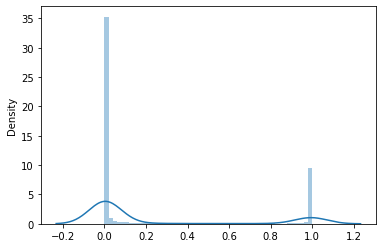

In [23]:
sns.distplot(resnet_pred)

## EfficientNet Model

In [12]:
from efficientnet_pytorch import EfficientNet

In [13]:
en_model = EfficientNet.from_pretrained("efficientnet-b2")
num_ftrs = en_model._fc.in_features
en_model._fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(en_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b2


  0%|          | 0/1010 [00:00<?, ?it/s]
Epoch 1/4
----------
  0%|          | 0/544 [00:00<?, ?it/s]
train Loss: 0.3476 Acc: 0.8427
100%|██████████| 544/544 [00:22<00:00, 23.67it/s]

val Loss: 0.1989 Acc: 0.9260
AUC score: 0.9179738800525318

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6230
           1       0.85      0.90      0.87      2464

    accuracy                           0.93      8694
   macro avg       0.90      0.92      0.91      8694
weighted avg       0.93      0.93      0.93      8694



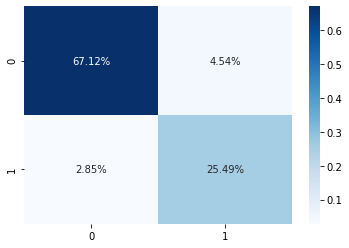

  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch 2/4
----------
  0%|          | 0/544 [00:00<?, ?it/s]
train Loss: 0.1356 Acc: 0.9478
100%|██████████| 544/544 [00:23<00:00, 23.60it/s]
val Loss: 0.1040 Acc: 0.9647
AUC score: 0.9605186597110755

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6230
           1       0.93      0.95      0.94      2464

    accuracy                           0.96      8694
   macro avg       0.95      0.96      0.96      8694
weighted avg       0.97      0.96      0.96      8694




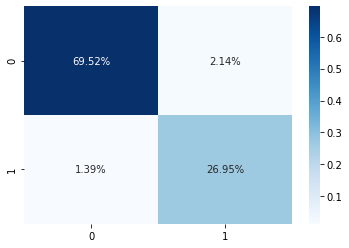

  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch 3/4
----------
  0%|          | 0/544 [00:00<?, ?it/s]
train Loss: 0.0846 Acc: 0.9698
100%|██████████| 544/544 [00:23<00:00, 23.65it/s]

val Loss: 0.0829 Acc: 0.9737
AUC score: 0.9624854078505765

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6230
           1       0.97      0.94      0.95      2464

    accuracy                           0.97      8694
   macro avg       0.97      0.96      0.97      8694
weighted avg       0.97      0.97      0.97      8694



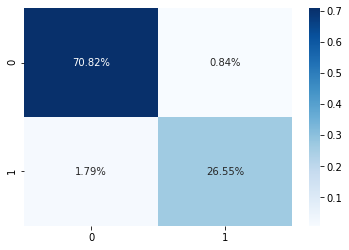

  0%|          | 0/1010 [00:00<?, ?it/s]

Epoch 4/4
----------
  0%|          | 0/544 [00:00<?, ?it/s]
train Loss: 0.0589 Acc: 0.9779
100%|██████████| 544/544 [00:23<00:00, 23.38it/s]
val Loss: 0.0758 Acc: 0.9767
AUC score: 0.9716866700715014

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6230
           1       0.96      0.96      0.96      2464

    accuracy                           0.98      8694
   macro avg       0.97      0.97      0.97      8694
weighted avg       0.98      0.98      0.98      8694




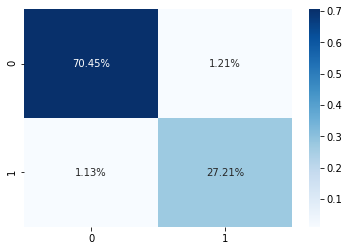


Training complete in 9m 42s
Best val Acc: 0.976651


In [14]:
en_model = train_model(en_model, criterion, optimizer, exp_lr_scheduler, num_epochs=4)

In [15]:
en_pred = prediction(en_model)

100%|██████████| 240/240 [00:09<00:00, 25.39it/s]


## Testing: defect scores

In [16]:
sample = pd.read_csv('submission_sample.csv')
submit_id = list(sample['id'])

In [17]:
test_id = [ img_id.replace('.bmp', '') for img_id in  testing_data['id']]
test_df = pd.DataFrame({"defect_score": en_pred}, index=test_id)
test_df = test_df.reindex(submit_id)
test_df.reset_index(inplace=True)
test_df = test_df.rename(columns = {'index':'id'})
test_df = test_df[['id', 'defect_score']]
test_df.head()

,id,defect_score
0,WEP937068H1A_21-5CW-ITISA46-1_254_2,2.888814e-06
1,WEP93700163A_51-APG_ITIS_H13_2_179_1,9.942244e-01
2,WEP937078H4A_38-5CW-ITISA44-1_42_2,4.497180e-05
3,WEA938001H3A_41-5CW-ITISA51-1_40_2,2.547802e-10
4,WEL92208756A_02-U3W-ITISA09-2_165_3,1.545617e-03


In [18]:
test_df.to_csv('test_en_score.csv', index=False)